<a href="https://colab.research.google.com/gist/jonghank/0500bf2fa45fde9611ed83c826d2ff05/kalman_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kalman filter


$$
\newcommand{\eg}{{\it e.g.}}
\newcommand{\ie}{{\it i.e.}}
\newcommand{\argmin}{\operatornamewithlimits{argmin}}
\newcommand{\mc}{\mathcal}
\newcommand{\mb}{\mathbb}
\newcommand{\mf}{\mathbf}
\newcommand{\minimize}{{\text{minimize}}}
\newcommand{\diag}{{\text{diag}}}
\newcommand{\cond}{{\text{cond}}}
\newcommand{\rank}{{\text{rank }}}
\newcommand{\range}{{\mathcal{R}}}
\newcommand{\null}{{\mathcal{N}}}
\newcommand{\tr}{{\text{trace}}}
\newcommand{\dom}{{\text{dom}}}
\newcommand{\dist}{{\text{dist}}}
\newcommand{\R}{\mathbf{R}}
\newcommand{\SM}{\mathbf{S}}
\newcommand{\ball}{\mathcal{B}}
\newcommand{\bmat}[1]{\begin{bmatrix}#1\end{bmatrix}}
$$

__<div style="text-align: right"> ASE7030: Convex Optimization, Inha University. </div>__
_<div style="text-align: right"> Jong-Han Kim (jonghank@inha.ac.kr) </div>_


<br>

A discrete-time linear dynamical system consists of a sequence of state vectors $x_t \in \R^n$, indexed by time $t\in \{0,\dots,N-1\}$ and dynamics equations

$$
\begin{aligned}
  x_{t+1} &= Ax_t + w_t \\
  y_{t} &= Cx_t + v_t   
\end{aligned}
$$

where $w_t\in\R^n$ is a disturbance to the dynamical system, $y_t\in\R^r$ is a state measurement, $v_t\in\R^r$ is noise, $A$ is the drift matrix, and $C$ is the observation matrix.

Given $A$, $C$, and $y_t$ for $t=0,\dots,N−1$, the goal is to estimate $x_t$ for $t=0,\dots,N−1$.

<br>

A Kalman filter estimates $x_t$ by solving the optimization problem 

$$
\begin{aligned}
  \underset{x,w,v}{\minimize} \quad & \sum_{t=0}^{N-1} \|w_t\|^2 + \tau\|v_t\|^2   \\
  \text{subject to} \quad & x_{t+1} = Ax_t + w_t\\
  & y_t = Cx_t + v_t, \qquad t=0,\dots,N-1 \
\end{aligned}
$$

with some tuning parameters $\tau$.

<br>

We'll apply standard Kalman filtering to a vehicle tracking problem with state $x_t\in\R^4$, where the first two states are the position of the vehicle in two dimensions, and the last two are the vehicle velocity. The vehicle has unknown disturbance $w_t$, and we observe noisy measurements of the vehicle's position, $y_t\in\R^2$.

Then the following matrices the above dynamics.

$$
A = \bmat{
1 & 0 & \left(1-0.5\gamma\Delta t\right)\Delta t & 0 \\
0 & 1 & 0 & \left(1-0.5\gamma\Delta t\right)\Delta t \\
0 & 0 & 1-\gamma\Delta t & 0 \\
0 & 0 & 0 & 1-\gamma\Delta t
} \\
C = \bmat{1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

n = 200 # number of timesteps
T = 100 # time will vary from 0 to T with step delt
ts = np.linspace(0,T,n+1)
delt = T/n
gamma = 0.05 # damping, 0 is no damping

A = np.zeros((4,4))
C = np.zeros((2,4))

A[0,0] = 1
A[1,1] = 1
A[0,2] = (1-gamma*delt/2)*delt
A[1,3] = (1-gamma*delt/2)*delt
A[2,2] = 1 - gamma*delt
A[3,3] = 1 - gamma*delt

C[0,0] = 1
C[1,1] = 1

<br>

The following simulates the system to $T=50$, with $\Delta t=0.5$, with
$$
{\bf E}(w_t w_t^T) = \bmat{ 0.01 & & & \\ & 0.01 & & \\ & & 0.1 & \\ & & & 0.1 }
$$
and 
$$
{\bf E}(v_t v_t^T) = \bmat{ 1 & \\ & 1 }
$$


In [2]:
from scipy.linalg import sqrtm 

np.random.seed(7030)

x = np.zeros((4,n+1))
x[:,0] = [0,0,0,0]
y = np.zeros((2,n))

Q = np.diag([0.01,0.01,0.1,0.1])
R = np.diag([1,1])
Qh = sqrtm(Q)
Rh = sqrtm(R)

w = Qh@np.random.randn(4,n)
v = Rh@np.random.randn(2,n)

for t in range(n):
    x[:,t+1] = A.dot(x[:,t]) + w[:,t]
    y[:,t]   = C.dot(x[:,t]) + v[:,t]
    
x_true = x.copy()
w_true = w.copy()
v_true = v.copy()

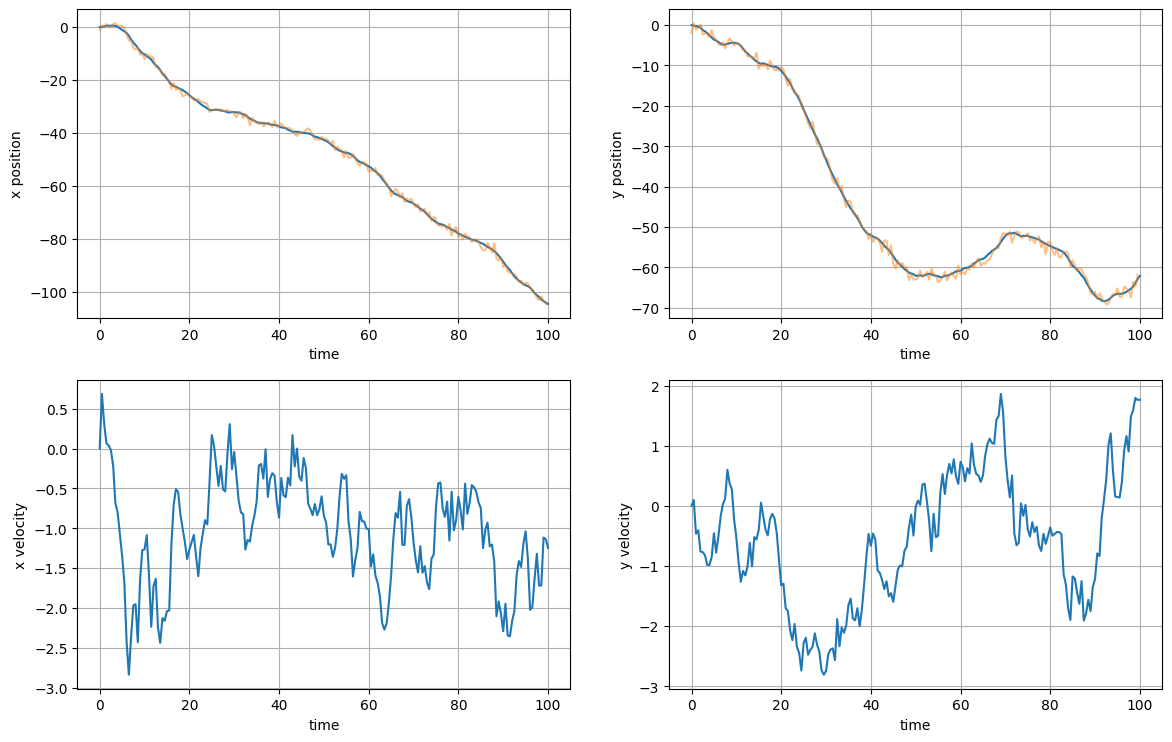

In [3]:
plt.figure(figsize=(14,9), dpi=100)
plt.subplot(2,2,1)
plt.plot(ts,x[0,:])
plt.plot(ts[:-1],y[0,:], alpha=0.5)
plt.xlabel('time')
plt.ylabel('x position')
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts,x[1,:])
plt.plot(ts[:-1],y[1,:], alpha=0.5)
plt.xlabel('time')
plt.ylabel('y position')
plt.grid()
plt.subplot(2,2,3)
plt.plot(ts,x[2,:])
plt.xlabel('time')
plt.ylabel('x velocity')
plt.grid()
plt.subplot(2,2,4)
plt.plot(ts,x[3,:])
plt.xlabel('time')
plt.ylabel('y velocity')
plt.grid()
plt.show()

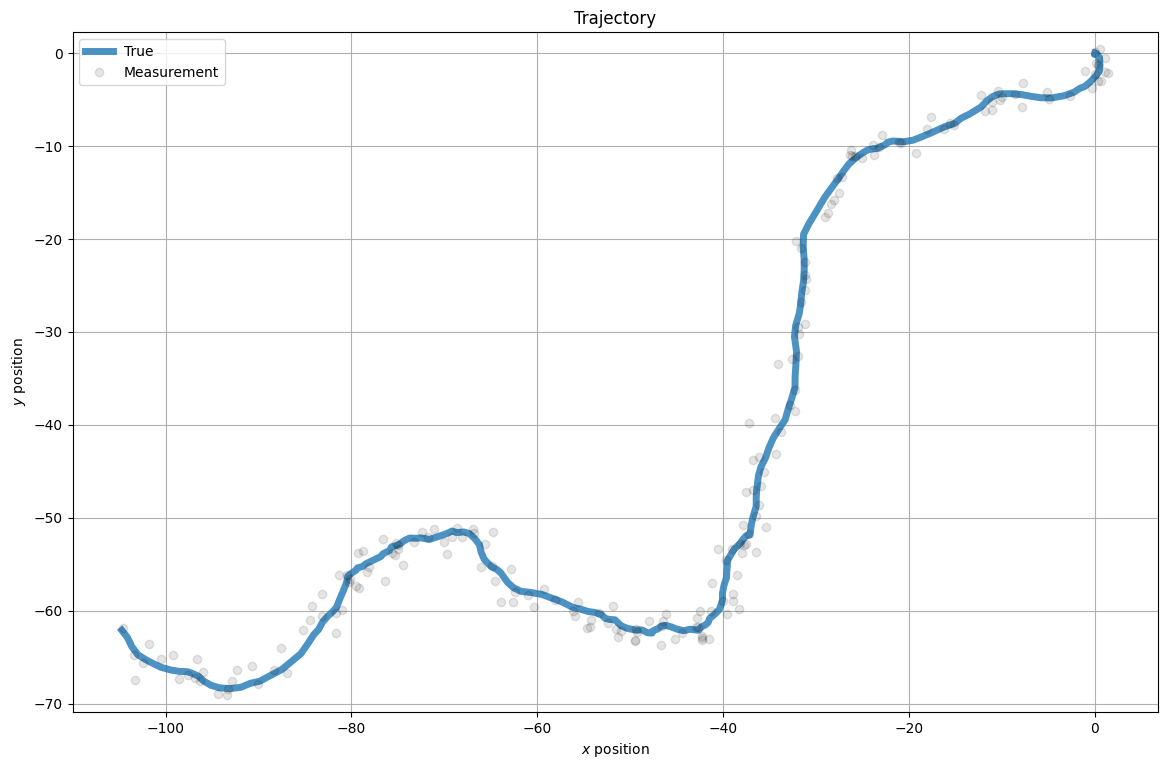

In [4]:
plt.figure(figsize=(14,9), dpi=100)
plt.plot(x[0,:],x[1,:],'-',alpha=0.8, linewidth=5, label='True')
plt.plot(y[0,:],y[1,:],'ko',alpha=0.1, label='Measurement')
plt.title('Trajectory')
plt.grid()
plt.legend()
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.axis('equal')
plt.show()

<br>

So your job is to find the optimal estimates on the blue curve (and possibly the velocity also) from the gray dots in the above trajectory plot.

<br>

Note the following relations.

$$
\begin{aligned}
  y_0 &= Cx_0 + v_0 \\
  y_1 &= Cx_1 + v_1 \\
  &= C(Ax_0 + w_0) + v_0 \\
  &= CAx_0 + C w_0 + v_1 \\
  y_2 &= Cx_2 + v_2 \\
  &= C(Ax_1 + w_1) + v_2 \\
  &= CAx_1 + C w_1 + v_2 \\
  &= CA(Ax_0+w_0) + C w_1 + v_2 \\
  &= CA^2x_0 + CAw_0 + Cw_1 + v_2  \\
  y_3 &= Cx_3 + v_3 \\
  &= C(Ax_2 + w_2) + v_3 \\
  &= CAx_2 + C w_2 + v_3 \\
  &= CA(Ax_1+w_1) + C w_2 + v_3 \\
  &= CA^2x_1 + CAw_1 + Cw_2 + v_3  \\
  &= CA^2(Ax_0+w_0) + CAw_1 + Cw_2 + v_3  \\
  &= CA^3x_0+CA^2w_0 + CAw_1 + Cw_2 + v_3   
\end{aligned}
$$

and in general
$$
y_t = CA^tx_0 + \bmat{CA^{t-1} & CA^{t-2} & \cdots & CA & C} 
\bmat{w_0 \\w_1 \\ \vdots \\ w_{t-2} \\ w_{t-1}} + v_t
$$

which implies that $y_t$ is linear in $x_0, w_0, \dots, w_{t-1}, v_t$.

<br>

Stacking the above relation for all $t=0,\dots,N$, you will essentially have

$$
\bmat{y_0 \\ y_1 \\ y_2 \\ \vdots \\ y_{N-1}}
=
\underbrace{
\bmat{C \\ CA \\ CA^2 \\ \vdots \\ CA^{N-1}}
}_{G}
x_0
+ 
\underbrace{
\bmat{
0  & \\ 
C & 0 \\ 
CA & C \\ 
\vdots        & \ddots        &          & \ddots &    & \\
CA^{N-2} & CA^{N-3} & \cdots & CA & C & 0}
}_{H}
\bmat{w_0 \\ w_1 \\ w_2 \\ \vdots \\ w_{N-1}}
+
\bmat{v_0 \\ v_1 \\ v_2 \\ \vdots \\ v_{N-1}}
$$

which we simply say
$$
y = Gx_0 + Hw + v
$$
where $y=(y_0, \dots, y_{N-1})$, $w=(w_0,\dots, w_{N-1})$, and $v = (v_0,\dots, v_{N-1})$.

<br>

Now the Kalman filtering problem is 

$$
\begin{aligned}
  \underset{x_0,w,v}{\minimize} \quad & \|w\|^2 + \tau\|v\|^2 \\
  \text{subject to} \quad & y = Gx_0 + Hw+v
\end{aligned}
$$

which is equivalent to 

$$
\begin{aligned}
  \underset{x_0,w,v}{\minimize} \quad & \left\| \bmat{ 0 & I & 0 \\ 0 & 0 & \sqrt{\tau} I }\bmat{x_0 \\ w \\ v} \right\|^2 \\
  \text{subject to} \quad & \bmat{G & H & I}\bmat{x_0 \\ w \\ v} = y
\end{aligned}
$$




<br> 

The solution can be obtained via solving,

$$
  \bmat{0 & 0 & 0 & G^T \\ 0 & I & 0 & H^T \\ 0 & 0 & \tau I & I \\ G & H & I & 0}\bmat{x_0 \\ w \\ v \\ \nu} = \bmat{0 \\ 0 \\ 0 \\ y}
$$

<br>

When is the above solvable? In other words, when can we determine $x_0$ without ambiguity?


In [5]:
import scipy.sparse as ssp
import scipy.sparse.linalg as sla

tau = 1

G = np.zeros( (2*n,4) )
for i in range(n):
  G[2*i:2*(i+1),:] = C@np.linalg.matrix_power(A,i)
  
H = np.zeros( (2*n,4*n) )
H_first = np.zeros( (2*n,4) )
for i in range(1,n):
  H_first[2*i:2*(i+1),:] = C@np.linalg.matrix_power(A,i-1)
for i in range(n):
  H[2*(i+1):,4*i:4*(i+1)] = H_first[2:2*(n-i),:]

A_1 = ssp.hstack(( ssp.csr_matrix((4*n,4)), ssp.eye(4*n),              ssp.csr_matrix((4*n,2*n)) ))
A_2 = ssp.hstack(( ssp.csr_matrix((2*n,4)), ssp.csr_matrix((2*n,4*n)), np.sqrt(tau)*ssp.eye(2*n) ))
A_tilde = ssp.vstack((A_1, A_2))
b_tilde = np.zeros(A_tilde.shape[0])
C_tilde = ssp.hstack(( G, H, ssp.eye(2*n) ))
d_tilde = y.T.flatten()

S_1 = ssp.hstack(( A_tilde.T@A_tilde, C_tilde.T                 ))
S_2 = ssp.hstack(( C_tilde,           ssp.csr_matrix((2*n,2*n)) ))
S = ssp.vstack(( S_1, S_2 ))
r = np.hstack(( A_tilde.T.dot(b_tilde), d_tilde ))
sol = sla.spsolve(S,r)

x_hat = sol[:A_tilde.shape[1]]

/usr/local/lib/python3.7/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


<br>

We can reconstruct $x_1, \dots, x_N$ from the estimates of $x_0$, $w_0,\dots,w_{N-1}$.

In [6]:
x0_hat = x_hat[:4]

w_kf_vec = x_hat[4:4*n+4]
v_kf_vec = x_hat[4*n+4:]

w_kf = w_kf_vec.reshape(n,4).T
v_kf = v_kf_vec.reshape(n,2).T

x_kf = np.zeros((4,n+1))
x_kf[:,0] = x0_hat

for t in range(n):
    x_kf[:,t+1] = A.dot(x_kf[:,t]) + w_kf[:,t]

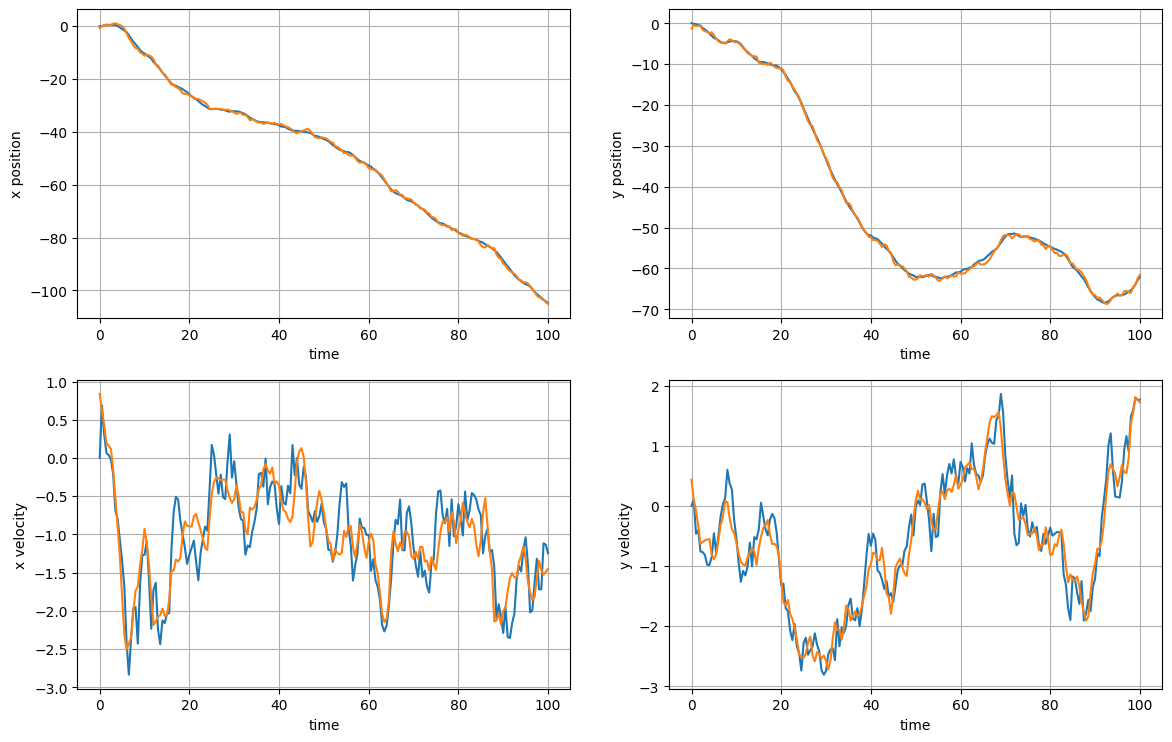

In [7]:
plt.figure(figsize=(14,9), dpi=100)
plt.subplot(2,2,1)
plt.plot(ts,x[0,:])
plt.plot(ts,x_kf[0,:])
plt.xlabel('time')
plt.ylabel('x position')
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts,x[1,:])
plt.plot(ts,x_kf[1,:])
plt.xlabel('time')
plt.ylabel('y position')
plt.grid()
plt.subplot(2,2,3)
plt.plot(ts,x[2,:])
plt.plot(ts,x_kf[2,:])
plt.xlabel('time')
plt.ylabel('x velocity')
plt.grid()
plt.subplot(2,2,4)
plt.plot(ts,x[3,:])
plt.plot(ts,x_kf[3,:])
plt.xlabel('time')
plt.ylabel('y velocity')
plt.grid()
plt.show()

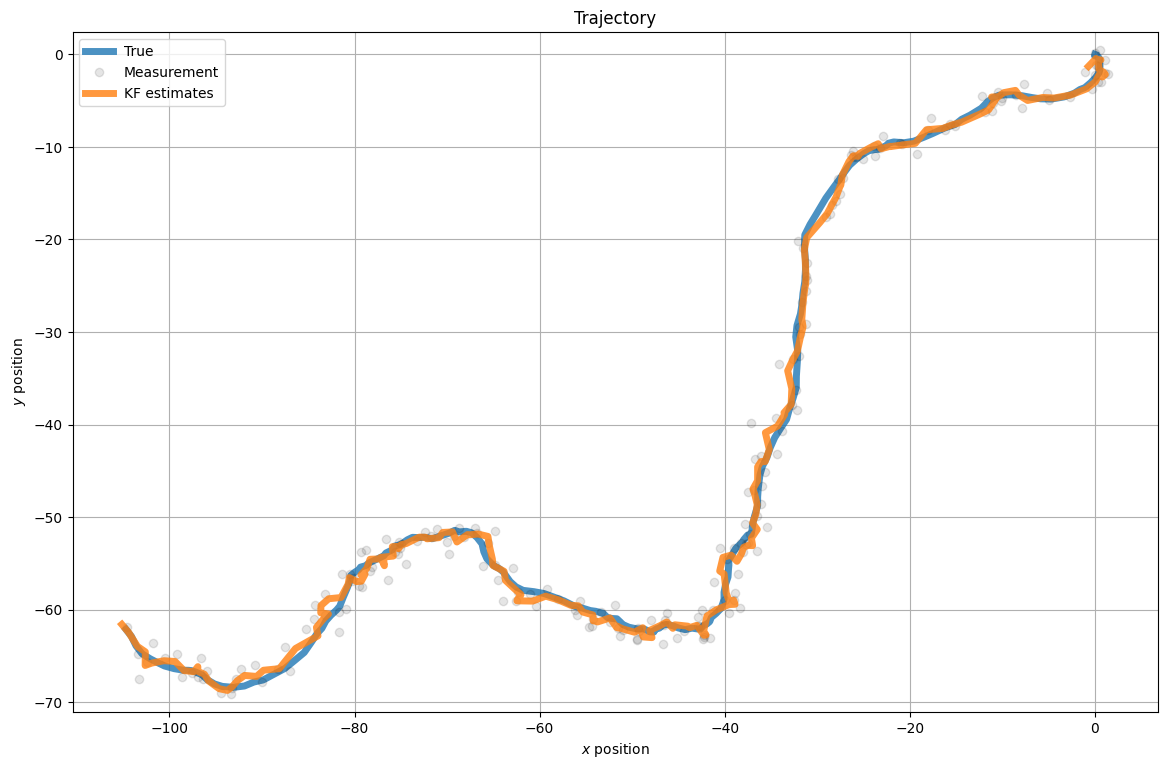

In [8]:
plt.figure(figsize=(14,9), dpi=100)
plt.plot(x[0,:],x[1,:],'-',alpha=0.8, linewidth=5, label='True')
plt.plot(y[0,:],y[1,:],'ko',alpha=0.1, label='Measurement')
plt.plot(x_kf[0,:],x_kf[1,:],'-',alpha=0.8, linewidth=5, label='KF estimates')
plt.title('Trajectory')
plt.grid()
plt.legend()
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.axis('equal')
plt.show()

<br>

Similar results can be obtained from the typical recursive implementation  .

In [9]:
Sigma_w = Q
Sigma_v = R
P = np.eye(4)

x_rk = np.zeros((4,n+1))
w_rk = np.zeros((4,n))
v_rk = np.zeros((2,n))
x_rk[:,0] = np.array([0,0,0,0])

for t in range(n):
  K = A@P@C.T@np.linalg.inv(C@P@C.T+Sigma_v)
  x_rk[:,t+1] = A@x_rk[:,t] + K@(y[:,t] - C@x_rk[:,t])
  P = A@P@A.T - K@C@P@A.T + Sigma_w
  w_rk[:,t] = x_rk[:,t+1] - A@x_rk[:,t]
  v_rk[:,t] = y[:,t] - C@x_rk[:,t]

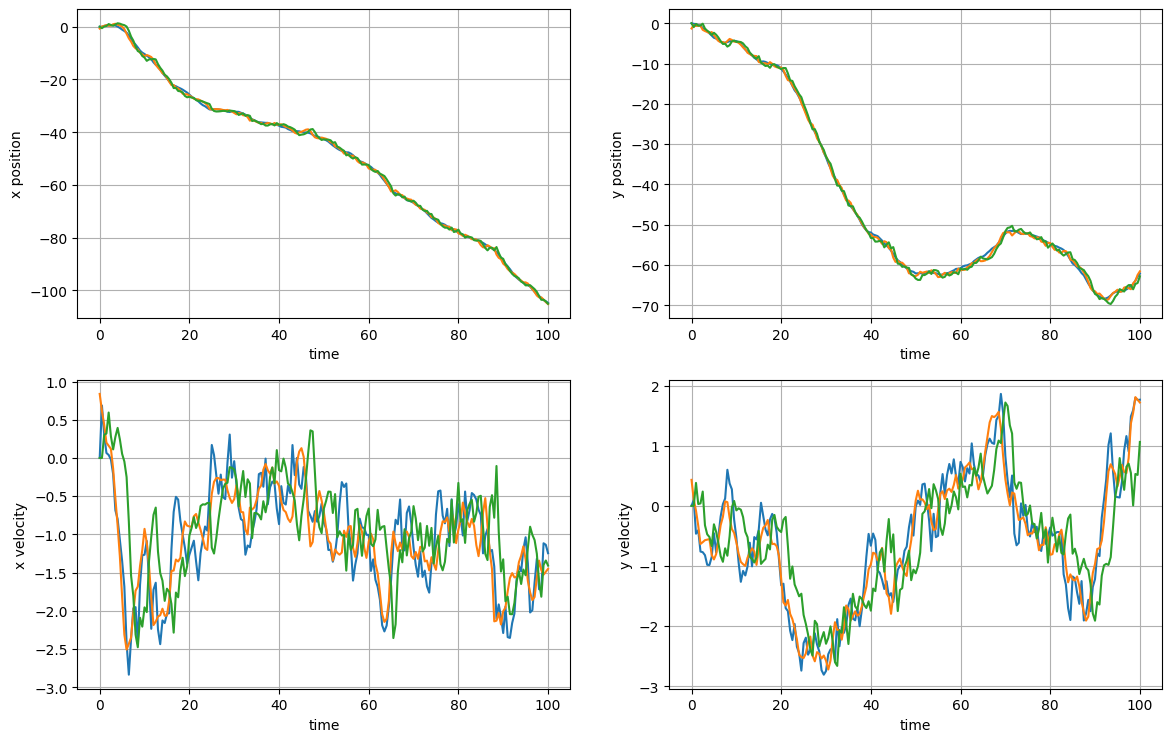

In [10]:
plt.figure(figsize=(14,9), dpi=100)
plt.subplot(2,2,1)
plt.plot(ts,x[0,:])
plt.plot(ts,x_kf[0,:])
plt.plot(ts,x_rk[0,:])
plt.xlabel('time')
plt.ylabel('x position')
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts,x[1,:])
plt.plot(ts,x_kf[1,:])
plt.plot(ts,x_rk[1,:])
plt.xlabel('time')
plt.ylabel('y position')
plt.grid()
plt.subplot(2,2,3)
plt.plot(ts,x[2,:])
plt.plot(ts,x_kf[2,:])
plt.plot(ts,x_rk[2,:])
plt.xlabel('time')
plt.ylabel('x velocity')
plt.grid()
plt.subplot(2,2,4)
plt.plot(ts,x[3,:])
plt.plot(ts,x_kf[3,:])
plt.plot(ts,x_rk[3,:])
plt.xlabel('time')
plt.ylabel('y velocity')
plt.grid()
plt.show()

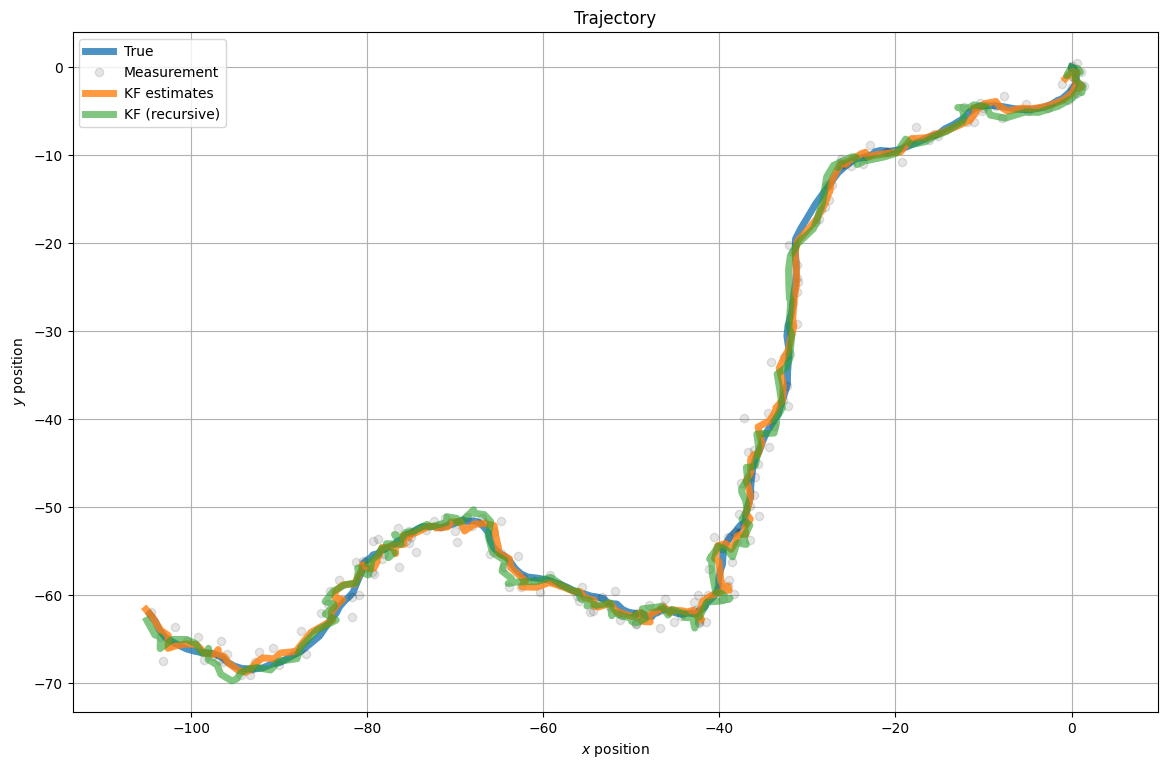

In [11]:
plt.figure(figsize=(14,9), dpi=100)
plt.plot(x[0,:],x[1,:],'-',alpha=0.8, linewidth=5, label='True')
plt.plot(y[0,:],y[1,:],'ko',alpha=0.1, label='Measurement')
plt.plot(x_kf[0,:],x_kf[1,:],'-',alpha=0.8, linewidth=5, label='KF estimates')
plt.plot(x_rk[0,:],x_rk[1,:],'-',alpha=0.6, linewidth=5, label='KF (recursive)')
plt.title('Trajectory')
plt.grid()
plt.legend()
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.axis('equal')
plt.show()